In [1]:
# Import the required libraries
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from peft import LoraConfig, get_peft_model
from ipywidgets import FileUpload, Text, Button, Output
from IPython.display import display
import io
import shutil
from wordcloud import WordCloud
import seaborn as sns
import numpy as np
import pandas as pd
import random

2025-04-25 00:47:06.663378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745542026.956159      88 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745542027.043477      88 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load dataset
base_path = "/kaggle/input/vizwiz"
annotations_path = f"{base_path}/Annotations/Annotations"
train_images_path = f"{base_path}/train/train"
val_images_path = f"{base_path}/val/val"
test_images_path = f"{base_path}/test/test"

# Load JSON annotations 
with open(f"{annotations_path}/train.json", "r") as f:
    train_data = json.load(f)
with open(f"{annotations_path}/val.json", "r") as f:
    val_data = json.load(f)
with open(f"{annotations_path}/test.json", "r") as f:
    test_data = json.load(f)

# Function to load image and metadata
def load_vizwiz_data(data, split="train"):
    images = []
    questions = []
    answers_list = []
    answer_types = []
    if split == "train":
        split_path = train_images_path
    elif split == "val":
        split_path = val_images_path
    else:
        split_path = test_images_path
    for item in data:
        img_path = f"{split_path}/{item['image']}"
        if os.path.exists(img_path):
            if  split != "test":
                images.append(Image.open(img_path))
                questions.append(item["question"])
                answers_list.append(item["answers"])
                answer_types.append(item.get("answer_type", "other"))
            else:
                images.append(Image.open(img_path))
                questions.append(item["question"])
    if split != "test":
        return {"image": images, "question": questions, "answers": answers_list, "answer_type": answer_types}
    else:
        return {"image": images, "question": questions}

# Load data (only train and val)
dataset = {
    "train": load_vizwiz_data(train_data, split="train"),
    "val": load_vizwiz_data(val_data, split="val"),
    "test": load_vizwiz_data(test_data, split="test")
}

# Print dataset sizes
print("Train:", len(dataset["train"]["image"]))
print("Validation:", len(dataset["val"]["image"]))
print("Test:", len(dataset["test"]["image"]))

Train: 20523
Validation: 4319
Test: 8000



--- EDA for TRAIN Split ---

Displaying 3 sample images from train split:


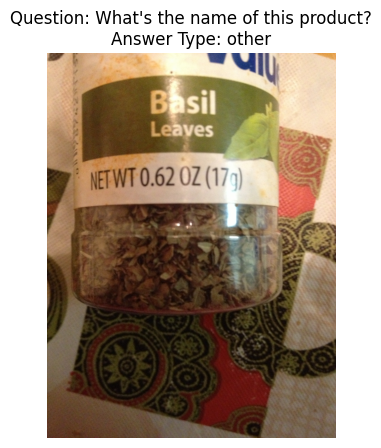

Answers: ['basil leaves', 'basil leaves', 'basil', 'basil', 'basil leaves', 'basil leaves', 'basil leaves', 'basil leaves', 'basil leaves', 'basil']
Most Frequent Answer: basil leaves
--------------------------------------------------


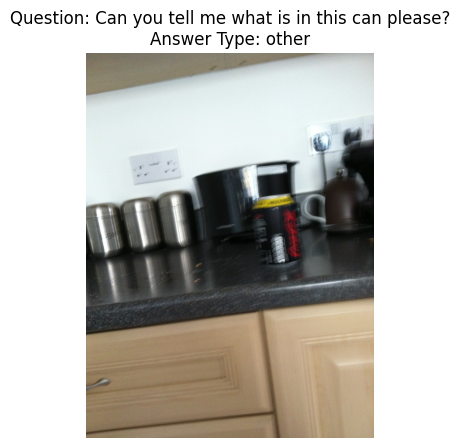

Answers: ['soda', 'coca cola', 'coca cola', 'unsuitable', 'unsuitable', 'coke 0', 'coca cola 0', 'coke 0', 'coca cola', 'coke']
Most Frequent Answer: coca cola
--------------------------------------------------


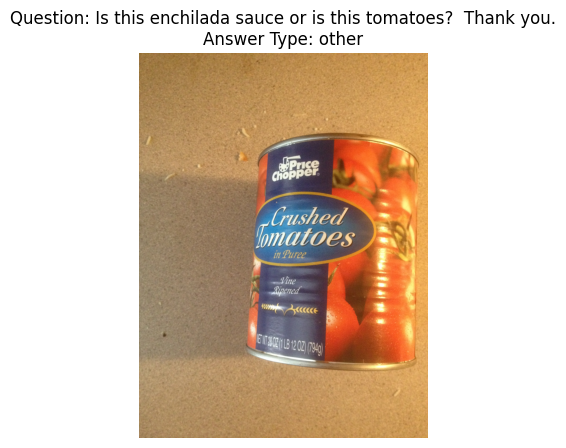

Answers: ['these tomatoes not enchilada sauce', 'tomatoes', 'tomatoes', 'tomatoes', 'tomatoes', 'crushed tomatoes', 'crushed tomatoes', 'tomatoes', 'tomatoes', 'tomatoes']
Most Frequent Answer: tomatoes
--------------------------------------------------


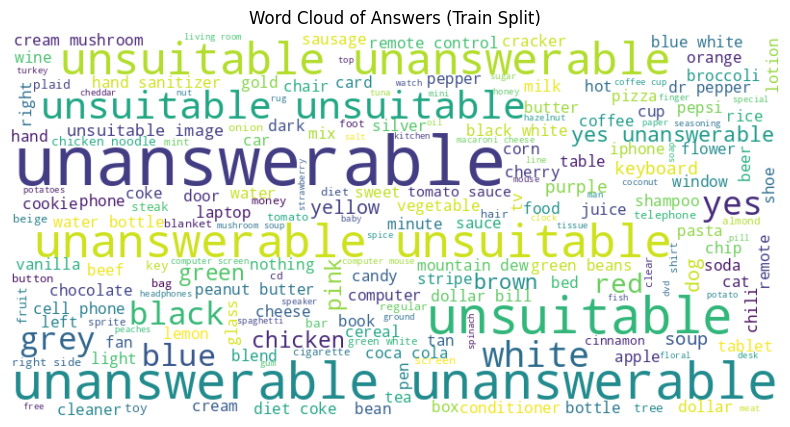

--------------------------------------------------


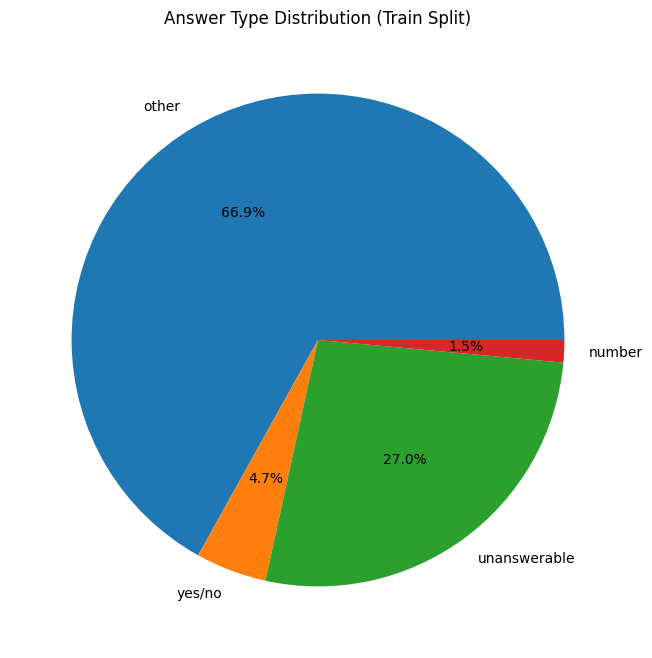

Answer Type Counts (train): Counter({'other': 13733, 'unanswerable': 5532, 'yes/no': 957, 'number': 301})
--------------------------------------------------
Unique Answers (train): 5598
--------------------------------------------------


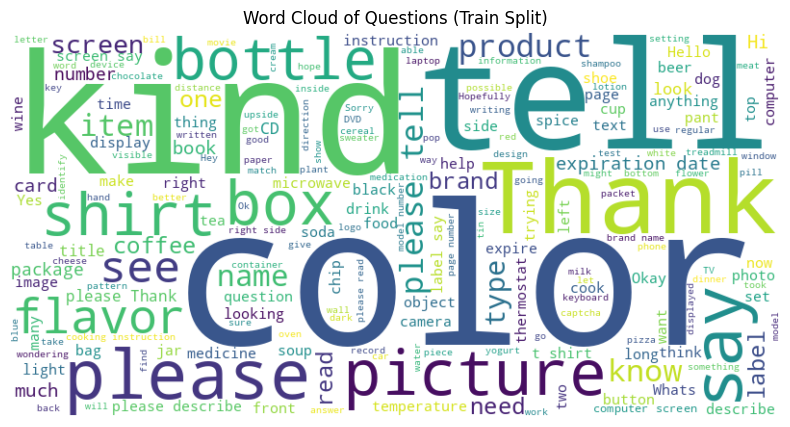

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


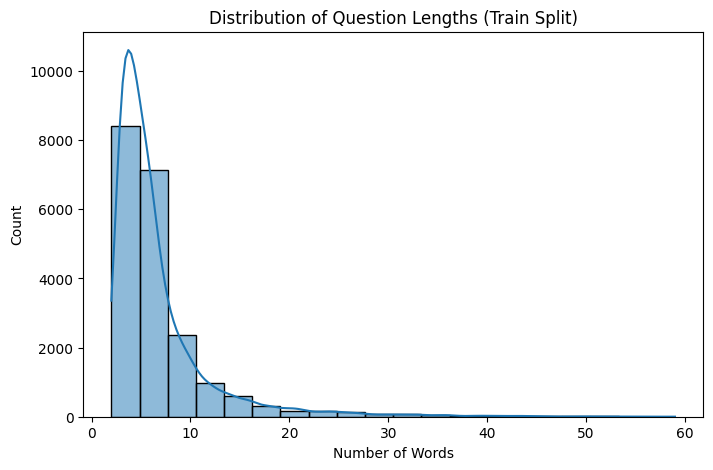

Average Question Length (train): 6.674072991278078
--------------------------------------------------

--- EDA for VAL Split ---

Displaying 3 sample images from val split:


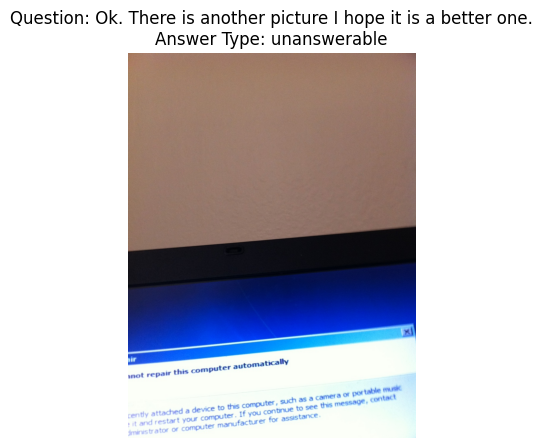

Answers: ['unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'unanswerable', 'cannot repair this computer automatically', 'blank screen']
Most Frequent Answer: unanswerable
--------------------------------------------------


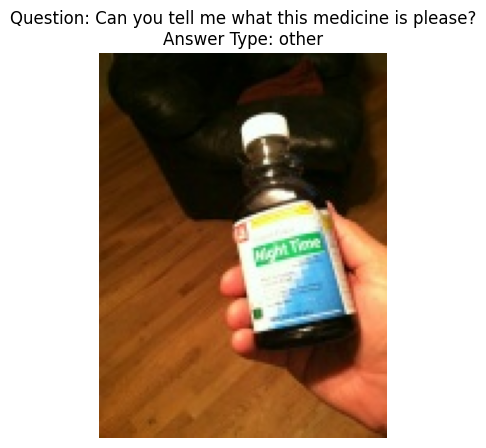

Answers: ['no', 'unsuitable image', 'night time', 'unsuitable image', 'night time', 'night time cold medicine', 'night time', 'night time', 'night time', 'night time medicine']
Most Frequent Answer: night time
--------------------------------------------------


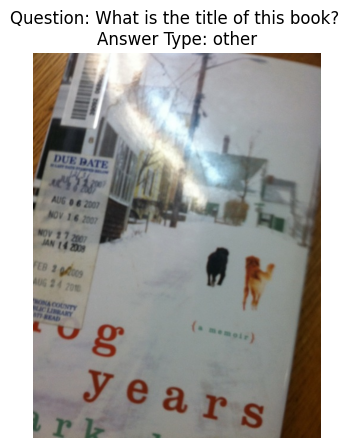

Answers: ['dog years', 'dog years: memoir', 'dog years', 'dog years', 'dog years', 'dog years', 'dog years', 'dog years', 'dog years', 'dog years']
Most Frequent Answer: dog years
--------------------------------------------------


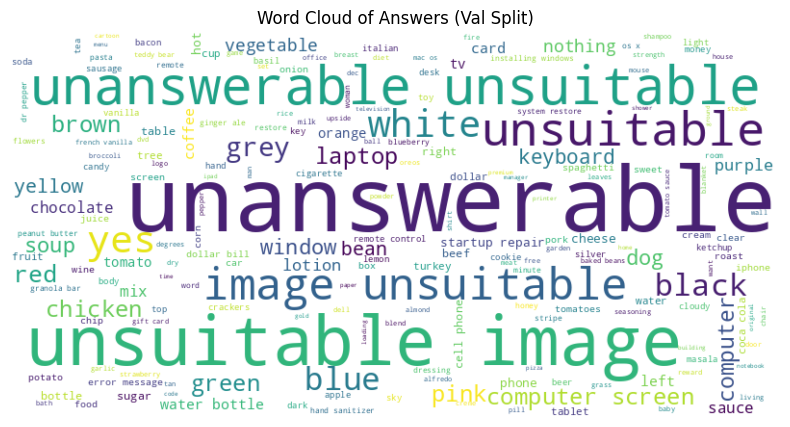

--------------------------------------------------


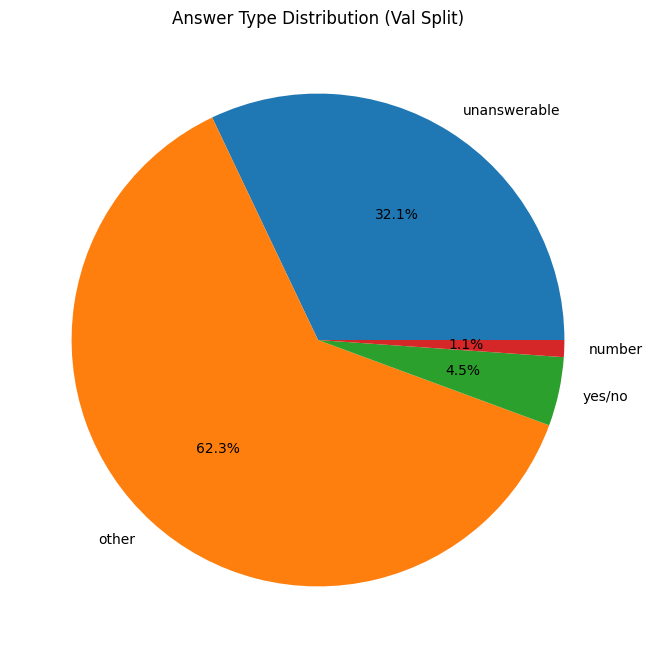

Answer Type Counts (val): Counter({'other': 2691, 'unanswerable': 1385, 'yes/no': 195, 'number': 48})
--------------------------------------------------
Unique Answers (val): 1499
--------------------------------------------------


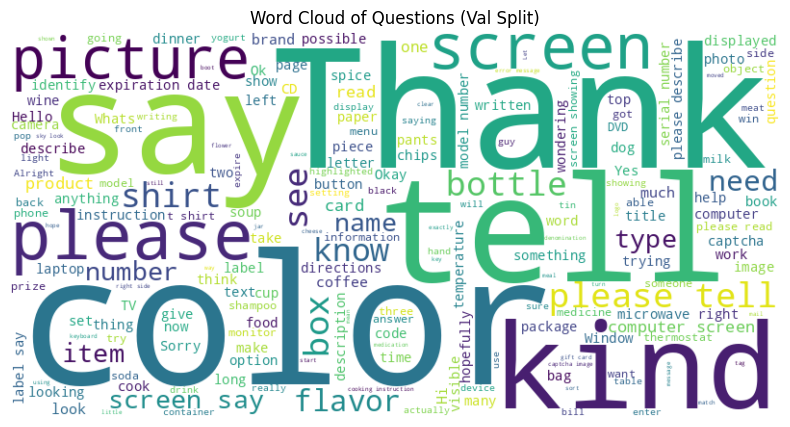

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


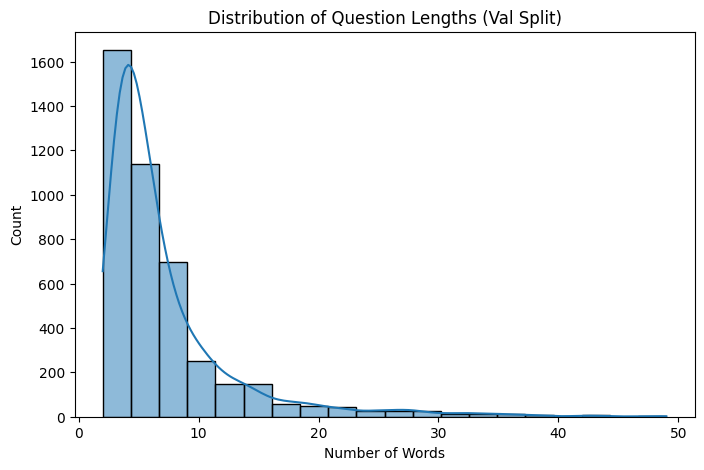

Average Question Length (val): 7.169483676777031
--------------------------------------------------

--- EDA for TEST Split ---

Displaying 3 sample images from test split:


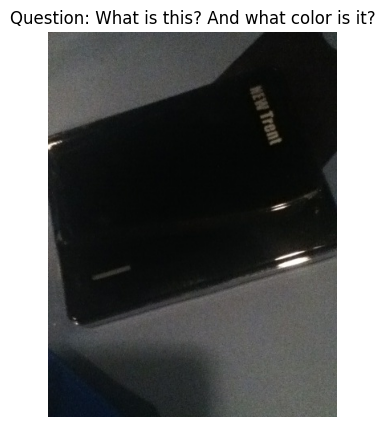

--------------------------------------------------


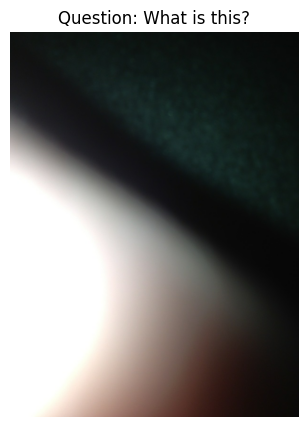

--------------------------------------------------


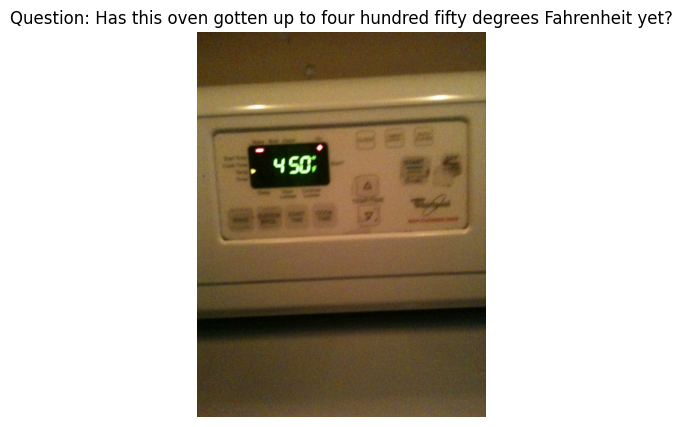

--------------------------------------------------


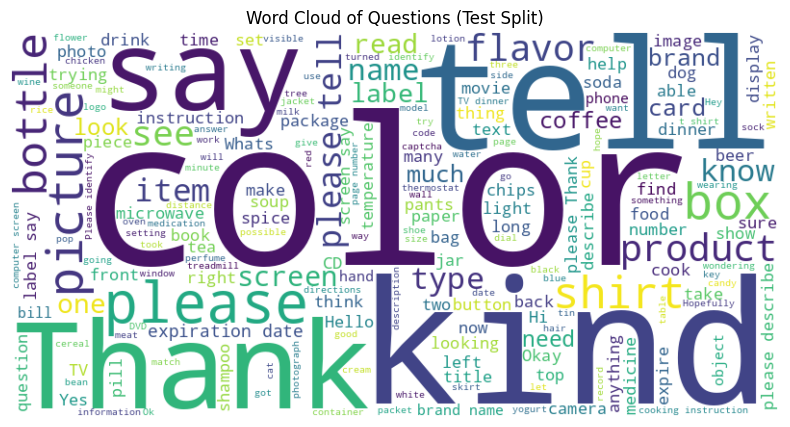

--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


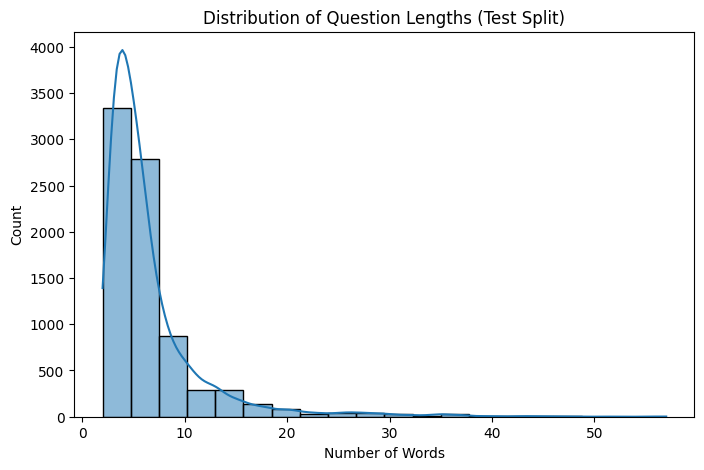

Average Question Length (test): 6.55925
--------------------------------------------------


In [3]:
# EDA on both train, val, and test splits
for split in ["train", "val", "test"]:
    print(f"\n--- EDA for {split.upper()} Split ---\n")

    # Sample-specific analysis: Display 3 sample images
    print(f"Displaying 3 sample images from {split} split:")
    for i in range(3):
        image = dataset[split]["image"][i]
        question = dataset[split]["question"][i]

        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        
        if split != "test":
            answers = [ans["answer"] for ans in dataset[split]["answers"][i]]
            answer_type = dataset[split]["answer_type"][i]
            plt.title(f"Question: {question}\nAnswer Type: {answer_type}")
            plt.axis("off")
            plt.show()
            print("Answers:", answers)
            print("Most Frequent Answer:", max(set(answers), key=answers.count))
        else:
            plt.title(f"Question: {question}")
            plt.axis("off")
            plt.show()
        print("-" * 50)

    # Split-level analysis for train and val splits
    if split != "test":
        # Word cloud for answers (using most frequent answer per sample)
        answers = [max(set([ans["answer"] for ans in sample]), key=[ans["answer"] for ans in sample].count) 
                   for sample in dataset[split]["answers"]]
        answers_text = " ".join(answers)
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(answers_text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(f"Word Cloud of Answers ({split.capitalize()} Split)")
        plt.axis("off")
        plt.show()
        print("-" * 50)

        # Pie chart of answer types
        answer_types = dataset[split]["answer_type"]
        answer_type_counts = Counter(answer_types)
        plt.figure(figsize=(8, 8))
        plt.pie(answer_type_counts.values(), labels=answer_type_counts.keys(), autopct="%1.1f%%")
        plt.title(f"Answer Type Distribution ({split.capitalize()} Split)")
        plt.show()
        print(f"Answer Type Counts ({split}):", answer_type_counts)
        print("-" * 50)

        # Unique answers
        unique_answers = len(set(answers))
        print(f"Unique Answers ({split}):", unique_answers)
        print("-" * 50)

    # Split-level analysis: Word cloud for questions
    questions = dataset[split]["question"]
    text = " ".join(questions)
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud of Questions ({split.capitalize()} Split)")
    plt.axis("off")
    plt.show()
    print("-" * 50)

    # Split-level analysis: Histogram of question lengths
    question_lengths = [len(q.split()) for q in dataset[split]["question"]]
    plt.figure(figsize=(8, 5))
    sns.histplot(question_lengths, bins=20, kde=True)
    plt.title(f"Distribution of Question Lengths ({split.capitalize()} Split)")
    plt.xlabel("Number of Words")
    plt.ylabel("Count")
    plt.show()
    print(f"Average Question Length ({split}):", sum(question_lengths) / len(question_lengths))
    print("-" * 50)

In [5]:
# We will combine the json files of train and val into single file and convert it to csv for ease of use
# We will then use the combined data for our train, val, test splits
# We'll also be excluding test file from the given dataset for training as it does not have answers, but will use it later for inference

# We'll not be considering answer type evaluation here, and out of the 10 answers we'll select the top answer and save it to our dataframe

# Function to get the most common answer
def get_most_common_answer(answers):
    answer_texts = [answer['answer'] for answer in answers]
    most_common = Counter(answer_texts).most_common(1)
    return most_common[0][0] if most_common else ""

# Function to convert data to DataFrame
def data_to_dataframe(data, split="train"):
    image_paths = []
    questions = []
    answers = []
    if split == "train":
        split_path = train_images_path
    elif split == "val":
        split_path = val_images_path
    else:
        split_path = test_images_path
    
    for item in data:
        img_path = f"{split_path}/{item['image']}"
        if os.path.exists(img_path):  # Ensure image exists
            if split != "test":
                image_paths.append(img_path)
                questions.append(item["question"])
                answers.append(get_most_common_answer(item["answers"]))
            else:
                image_paths.append(img_path)
                questions.append(item["question"])
    
    # Create DataFrame
    if split != "test":
        df = pd.DataFrame({
            'image_path': image_paths,
            'question': questions,
            'answer': answers
        })
    else:
        df = pd.DataFrame({
            'image_path': image_paths,
            'question': questions
        })
    return df

# Convert train and val data to DataFrames
train_df = data_to_dataframe(train_data, split="train")
val_df = data_to_dataframe(val_data, split="val")
test_df = data_to_dataframe(test_data, split="test")

# Combine train and val into a single DataFrame
combined_df = pd.concat([train_df, val_df], ignore_index=True)

# Save to CSV files
output_dir = "/kaggle/working/"  
combined_csv_path = f"{output_dir}vizwiz_combined.csv"
train_csv_path = f"{output_dir}vizwiz_train.csv"
val_csv_path = f"{output_dir}vizwiz_val.csv"
test_csv_path = f"{output_dir}vizwiz_test.csv"

combined_df.to_csv(combined_csv_path, index=False)
train_df.to_csv(train_csv_path, index=False)
val_df.to_csv(val_csv_path, index=False)
test_df.to_csv(test_csv_path, index=False)

# Print confirmation and DataFrame sizes
print(f"Combined CSV saved to {combined_csv_path}")
print(f"Train CSV saved to {train_csv_path}")
print(f"Validation CSV saved to {val_csv_path}")
print(f"Test CSV saved to {test_csv_path}")
print("Train DataFrame rows:", len(train_df))
print("Validation DataFrame rows:", len(val_df))
print("Test DataFrame rows:", len(test_df))
print("Combined DataFrame rows:", len(combined_df))

Combined CSV saved to /kaggle/working/vizwiz_combined.csv
Train CSV saved to /kaggle/working/vizwiz_train.csv
Validation CSV saved to /kaggle/working/vizwiz_val.csv
Test CSV saved to /kaggle/working/vizwiz_test.csv
Train DataFrame rows: 20523
Validation DataFrame rows: 4319
Test DataFrame rows: 8000
Combined DataFrame rows: 24842
